# TM10007 Assignment template

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [991]:
# # Run this to use from colab environment
# !pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [992]:
from load_data import load_data
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, SequentialFeatureSelector, SelectFromModel
from sklearn.linear_model import Lasso
import seaborn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from scipy import stats
from statsmodels.stats import weightstats
import numpy as np
import statistics
from time import time
import matplotlib.pyplot as plt

# Classifiers and kernels

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn import metrics


data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

features = data.drop(columns=['label'])
label = data.label


# Splitting data in train and test group
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=.2)

# functie van maken??

def binner(y, class1):
  y_bin = []
  for val in y:
    if val == class1:
      y_bin.append(0)
    else:
      y_bin.append(1) 
  return y_bin
  
y_train_bin = binner(y_train, 'T12')
y_test_bin = binner(y_test, 'T12')

The number of samples: 113
The number of columns: 160


## Preprocessing

### Removing outliers

In [993]:
# Create the dataframe
outlier_feat = []
for feature in X_train.columns:
    # IQR
    Q1 = np.percentile(X_train[feature], 25,
                    interpolation = 'midpoint')
    
    Q3 = np.percentile(X_train[feature], 75,
                    interpolation = 'midpoint')
    IQR = Q3 - Q1
 
    if not IQR == 0:
        # Upper bound
        X_train.loc[X_train[feature] > (Q3+1.5*IQR),feature] = Q3
        # Lower bound
        X_train.loc[X_train[feature] < (Q1-1.5*IQR),feature] = Q1


for feature in X_test.columns:
    
    # IQR
    Q1 = np.percentile(X_test[feature], 25,
                    interpolation = 'midpoint')
    
    Q3 = np.percentile(X_test[feature], 75,
                    interpolation = 'midpoint')
    IQR = Q3 - Q1
    
    if not IQR == 0:
        # Upper bound
        X_test.loc[X_test[feature] > (Q3+1.5*IQR),feature] = Q3
        # Lower bound
        X_test.loc[X_test[feature] < (Q1-1.5*IQR),feature] = Q1


/Users/bramschalkwijk/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### Scaling

In [994]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = features.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = features.columns)


## Feature selection

### T-test

In [995]:
# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = X_train.columns) # make df from numpy
# X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = X_train.columns)
# X_train_scaled_df['Label'] = y_train_bin
# X_train_T12 = X_train_scaled_df.groupby('Label').get_group(0)
# X_train_T34 = X_train_scaled_df.groupby('Label').get_group(1)
# X_train_T12 = X_train_T12.drop(columns = ['Label'])
# X_train_T34 = X_train_T34.drop(columns = ['Label'])

# # ttest
# _,pval = stats.ttest_ind(X_train_T12,X_train_T34)



# sig_feat = []
# for id, val in enumerate(pval):
#   if val < 0.05/X_train_scaled_df.shape[1]:
#     sig_feat.append(list(X_train.columns)[id])
# print(f'Number of significant different features: {len(sig_feat)}')

# X_train_sig = X_train_scaled_df[sig_feat]
# X_test_sig = X_test_scaled_df[sig_feat]

# # # Pairplot of sign features
# # X_train_sig.columns =['Feature'+ str(pc) for pc in range(1,len(sig_feat)+1)]
# # X_train_sig['Grade'] = y_train_bin
# # pair_plot = seaborn.pairplot(X_train_sig, hue = 'Grade')

### Greedy

In [996]:
# cfs = RandomForestClassifier(n_estimators=5, bootstrap=True)


# t_it = np.zeros(159)
# for it in range(20):
#     print(it)
#     cfs = KNeighborsClassifier(n_neighbors=5)
#     sfs = SequentialFeatureSelector(cfs,n_features_to_select=5)
#     X_train_fs = sfs.fit_transform(X_train_scaled, y_train)
#     it = sfs.get_support()
#     t_it = np.vstack([t_it,it])


# voting = np.sum(t_it, axis=0)

# THRES = 10
# sig_feat = []
# for id, value in enumerate(voting):
#     if value > THRES:
#         sig_feat.append(list(X_train.columns)[id])

# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = X_train.columns) # make df from numpy
# X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = X_train.columns)
# X_train_sig = X_train_scaled_df[sig_feat]
# X_test_sig = X_test_scaled_df[sig_feat]

# X_train_sig
# # X_test_fs = sfs.transform(X_test_scaled)








# cfs = KNeighborsClassifier(n_neighbors=5)
# sfs = SequentialFeatureSelector(cfs,n_features_to_select=60)
# X_train_fs = sfs.fit_transform(X_train_scaled, y_train)
# X_test_fs = sfs.transform(X_test_scaled)


### LASSO

/Users/bramschalkwijk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00437794722659379, tolerance: 0.004
  model = cd_fast.enet_coordinate_descent(
/Users/bramschalkwijk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005275064159275562, tolerance: 0.004
  model = cd_fast.enet_coordinate_descent(
/Users/bramschalkwijk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0063669075736558995, tolerance: 0.004
  model = cd_fast.enet_coordinate_descent(
/Users/bramschalkwijk/opt/anaconda3/lib/python3.9/site-packages/sklearn/l

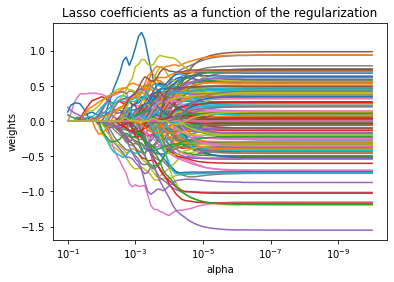

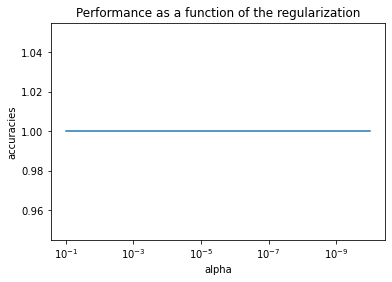

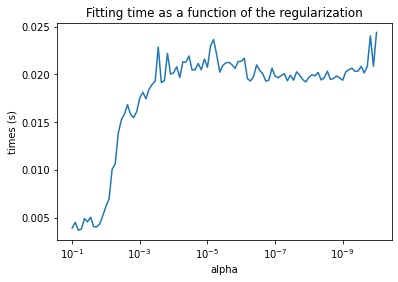

In [997]:
# Construct classifiers
coefs = []
accuracies = []
times = []

n_alphas = 100
alphas = np.logspace(-10, -1, n_alphas)

for a in alphas:
    # Fit classifier
    clf = Lasso(alpha=a, fit_intercept=False)
    t0 = time()
    clf.fit(X_train_scaled, y_train_bin)
    duration = time() - t0
    y_pred = clf.predict(X_test_scaled)
    
    # Append statistics
    accuracy = float((y_test_bin != y_pred).sum()) / float(len(y_test_bin))
    times.append(duration)
    accuracies.append(accuracy)
    coefs.append(clf.coef_)

# #############################################################################
# Display results

# Weights
plt.figure()
ax = plt.gca()
ax.plot(alphas, np.squeeze(coefs))
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

# Performance
plt.figure()
ax = plt.gca()
ax.plot(alphas, accuracies)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('accuracies')
plt.title('Performance as a function of the regularization')
plt.axis('tight')
plt.show()

# Times
plt.figure()
ax = plt.gca()
ax.plot(alphas, times)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('times (s)')
plt.title('Fitting time as a function of the regularization')
plt.axis('tight')
plt.show()

In [998]:
selector = SelectFromModel(estimator=Lasso(alpha=10**(-7)), threshold='median')
selector.fit(X_train_scaled, y_train_bin)
n_original = X_train_scaled.shape[1]
X_train_fs = selector.transform(X_train_scaled)
X_test_fs = selector.transform(X_test_scaled)
n_selected = X_train_fs.shape[1]
print(f"Selected {n_selected} from {n_original} features.")


selector.threshold_

Selected 80 from 159 features.


0.28164810176588173

### Learning curves

In [999]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

<module 'matplotlib.pyplot' from '/Users/bramschalkwijk/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

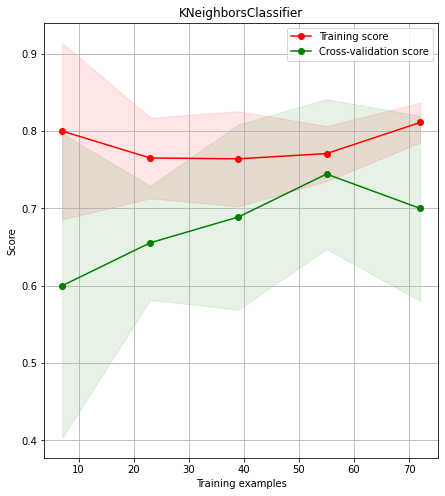

In [1002]:
title = 'KNeighborsClassifier'
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(1, 3, 1)

# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(KNeighborsClassifier(), title, X_train_fs, y_train_bin, axes = ax, cv = 5)

## PCA

In [923]:
N_COMP = .9
pca = PCA(n_components=N_COMP)
pca.fit(X_train_fs)
X_train_pca = pca.transform(X_train_fs)
X_test_pca = pca.transform(X_test_fs)

X_test_pca.shape[1]
# seaborn.scatterplot(x=X_train_pca[:,0],y=X_train_pca[:,1],hue=y_train)
# scatter_data = pd.DataFrame(X_train_pca[:,:], columns = ['Principal component' + str(pc) for pc in range(1,N_COMP+1)])
# scatter_data['Stage'] = y_train_bin
# seaborn.pairplot(scatter_data, hue = 'Stage')
# print(scatter_data)

22

# Classifier

In [920]:

X_train_sig = X_train_pca
X_test_sig = X_test_pca

# Construct classifiers
svmlin = SVC(kernel='linear', gamma='scale')
svmrbf = SVC(kernel='rbf', gamma='scale')
svmpoly = SVC(kernel='poly', degree=3, gamma='scale')

# clsfs = [KNeighborsClassifier(), RandomForestClassifier(),QuadraticDiscriminantAnalysis(),GaussianNB(),LinearDiscriminantAnalysis(),svmlin, svmpoly, svmrbf]
clsfs = [KNeighborsClassifier(n_neighbors=10)]

for clf in clsfs:
    # Fit classifier
    clf.fit(X_train_sig,y_train)
    y_pred_train=clf.predict(X_train_sig)
    print(clf)
    acc_train = (y_train==y_pred_train).sum()/len(X_train_sig)
    print(f'Train data acc: {acc_train}')
    y_pred_test = clf.predict(X_test_sig)
    acc_test = (y_test==y_pred_test).sum()/len(X_test_sig)
    print(f'Test data acc: {acc_test}')



KNeighborsClassifier(n_neighbors=10)
Train data acc: 0.8
Test data acc: 0.6956521739130435


#### Optimization

In [943]:
## Optimization
### KNN
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=5)
results = []
best_n_neighbors = []
X_train_sig_a = X_train_sig
y_train_a = y_train.to_numpy()

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_sig_a,y_train_a):
    # Split the data properly
    X_validation = X_train_sig_a[validation_index]
    y_validation = y_train_a[validation_index]
    
    X_test_op = X_train_sig_a[test_index]
    y_test_op = y_train_a[test_index]
    
    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_neighbors": list(range(1, 31, 2))}
    knn = KNeighborsClassifier()
    cv_10fold = model_selection.StratifiedKFold(n_splits=5)
    grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: k={clf.n_neighbors}')
    best_n_neighbors.append(clf.n_neighbors)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test_op)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_test_op, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'k': clf.n_neighbors,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
# seaborn.boxplot(y='auc', x='set', data=results)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")
# print(results)


# Use the optimal parameters without any tuning to validate the optimal classifier
clf = KNeighborsClassifier(n_neighbors=optimal_n)

# Fit on the entire dataset
clf.fit(X_train_sig, y_train)

# Test the classifier on the indepedent replication data
probabilities = clf.predict_proba(X_test_sig)
scores = probabilities[:, 1]

# Get the auc
auc = metrics.roc_auc_score(y_test, scores)
print(f'THe AUC on the replication set is {auc} using a {clf.n_neighbors}-NN classifier')


knn = KNeighborsClassifier(n_neighbors=optimal_n)
knn.fit(X_train_sig, y_train)
score_train_kNN = knn.score(X_train_sig, y_train)
score_test_kNN = knn.score(X_test_sig, y_test)
print(f"Training result kNN: {score_train_kNN}")
print(f"Test result kNN: {score_test_kNN}")

Best classifier: k=29
Best classifier: k=13
Best classifier: k=17
Best classifier: k=17
Best classifier: k=9
The optimal N=17
THe AUC on the replication set is 0.7538461538461538 using a 17-NN classifier
Training result kNN: 0.7888888888888889
Test result kNN: 0.5652173913043478


### RF

Best classifier: n=38
Best classifier: n=32
Best classifier: n=21
Best classifier: n=23
Best classifier: n=44
The optimal N=32
        auc   n         set
0  0.864198  38        test
1  0.996914  38  validation
2  0.641975  32        test
3  0.993827  32  validation
4  0.666667  21        test
5  0.997685  21  validation
6  0.827160  23        test
7  0.998457  23  validation
8  0.530864  44        test
9  0.993056  44  validation


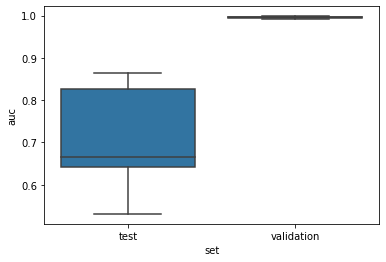

In [944]:
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=5)
results = []
best_n_neighbors = []
X_train_sig_a = X_train_sig
y_train_a = y_train.to_numpy()

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_sig_a,y_train_a):
    # Split the data properly
    X_validation = X_train_sig_a[validation_index]
    y_validation = y_train_a[validation_index]
    
    X_test = X_train_sig_a[test_index]
    y_test = y_train_a[test_index]
    
    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_estimators": list(range(1, 50))}
    rf = RandomForestClassifier(criterion= "gini", bootstrap = True, min_samples_leaf = 5)
    cv_10fold = model_selection.StratifiedKFold(n_splits=5)
    grid_search = model_selection.GridSearchCV(rf, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: n={clf.n_estimators}')
    best_n_neighbors.append(clf.n_estimators)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_test, scores)
    results.append({
        'auc': auc,
        'n': clf.n_estimators,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'n': clf.n_estimators,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
seaborn.boxplot(y='auc', x='set', data=results)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")
print(results)
